In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import math
from sklearn.metrics import mean_squared_error

In [42]:
# Load and prepare the data
df = pd.read_csv("NIFTY 50_Historical_PR_17082010to17082024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data = df[['Date', 'Close']].set_index('Date')

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=['Close'])

In [255]:
# Define the time step and the prediction period
time_step = 100


In [256]:
# Get the last 3 months for testing
last_3_months = 3 * 100  
test_data = scaled_df[-last_3_months:]
train_data = scaled_df[:-last_3_months]

In [257]:
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:(i + time_step), 0])
        y.append(data.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [258]:
len(X_test[0])

100

In [259]:
# Build and train the LSTM model
model = Sequential()
model.add(Input(shape=(time_step, 1)))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test))


Epoch 1/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - loss: 0.0219 - val_loss: 9.0661e-04
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0013 - val_loss: 3.0336e-04
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 0.0012 - val_loss: 0.0026
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 8.8220e-04 - val_loss: 0.0022
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 8.0297e-04 - val_loss: 0.0026
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.5721e-04 - val_loss: 7.6742e-04
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 7.1063e-04 - val_loss: 0.0018
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 5.9505e-04 - val_loss: 0.0014
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.0516e-04 - val_loss: 0.0018
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 6.0286e-04 - val_loss: 0.0013
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 5.6898e-04 - val_loss: 2.2745e-04
Epoc

In [267]:
history = model.fit(X_train, y_train, batch_size=64, epochs=1, validation_data=(X_test, y_test))

48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 3.4370e-04 - val_loss: 1.5076e-04


In [268]:
# Evaluate the model on the last 3 months
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE for the last 3 months
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Test RMSE (Last 3 months): {test_rmse}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Test RMSE (Last 3 months): 22154.569958275988


C:\Users\kk196\AppData\Local\Temp\ipykernel_22948\317418498.py:5: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_year_data = data.last(f"{one_year}D")  # Last year of data


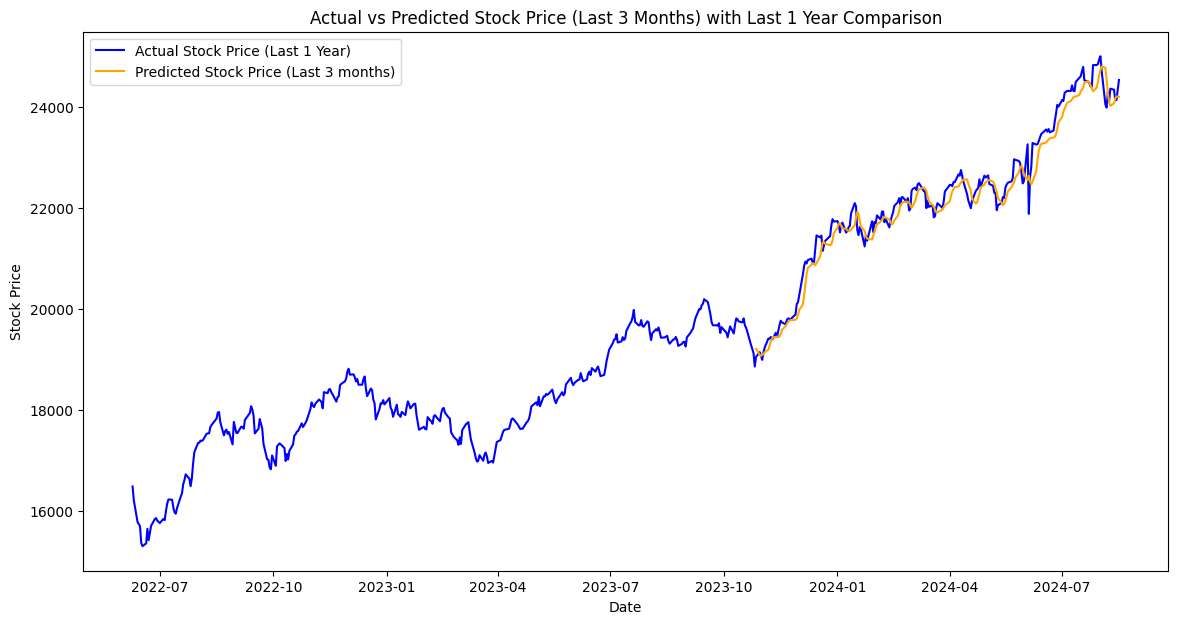

In [269]:
# Define the time period for comparison
one_year = 800  # Adjust as needed if not precisely 365 days

# Extract the last year of actual data
last_year_data = data.last(f"{one_year}D")  # Last year of data

# Extract the indices for the last year of actual data
last_year_index = last_year_data.index

# Extract the last 3 months of actual data (aligned with test data)
last_3_months_index = data.index[-len(test_predict):]

# Plot 1: Comparison of the last 3 months actual vs predicted with 1-year window
plt.figure(figsize=(14, 7))

# Plot whole last year data
plt.plot(last_year_data.index, last_year_data['Close'], label='Actual Stock Price (Last 1 Year)', color='blue')

# Plot predicted values
plt.plot(last_3_months_index, test_predict, label='Predicted Stock Price (Last 3 months)', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price (Last 3 Months) with Last 1 Year Comparison')
plt.legend()
plt.show()


In [270]:
scaled_df

,Close
Date,
2010-08-17,0.042506
2010-08-18,0.045682
2010-08-19,0.048664
2010-08-20,0.048198
2010-08-23,0.048826
...,...
2024-08-09,0.968564
2024-08-12,0.967562
2024-08-13,0.957399


In [274]:
def predict_nxt_yr():
    last_60_days = scaled_df['Close'].to_list()[-100:]
    for _ in range(300):
        last_60_days_new = last_60_days[-100:]
        array = np.array(last_60_days_new)
        reshaped_data = array.reshape(1, time_step, 1)
        result = model.predict(reshaped_data)
        last_60_days.append(result[0][0])
    return last_60_days
nxt_yr = predict_nxt_yr()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━

In [275]:
future_predictions = scaler.inverse_transform(np.array(nxt_yr).reshape(-1, 1))

In [276]:
len(future_predictions)

400

In [277]:
last_date = df['Date'].iloc[-1]
last_date

Timestamp('2024-08-16 00:00:00')

In [279]:
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=300, freq='B')

In [280]:
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted_Close': future_predictions.flatten().tolist()[100:]})

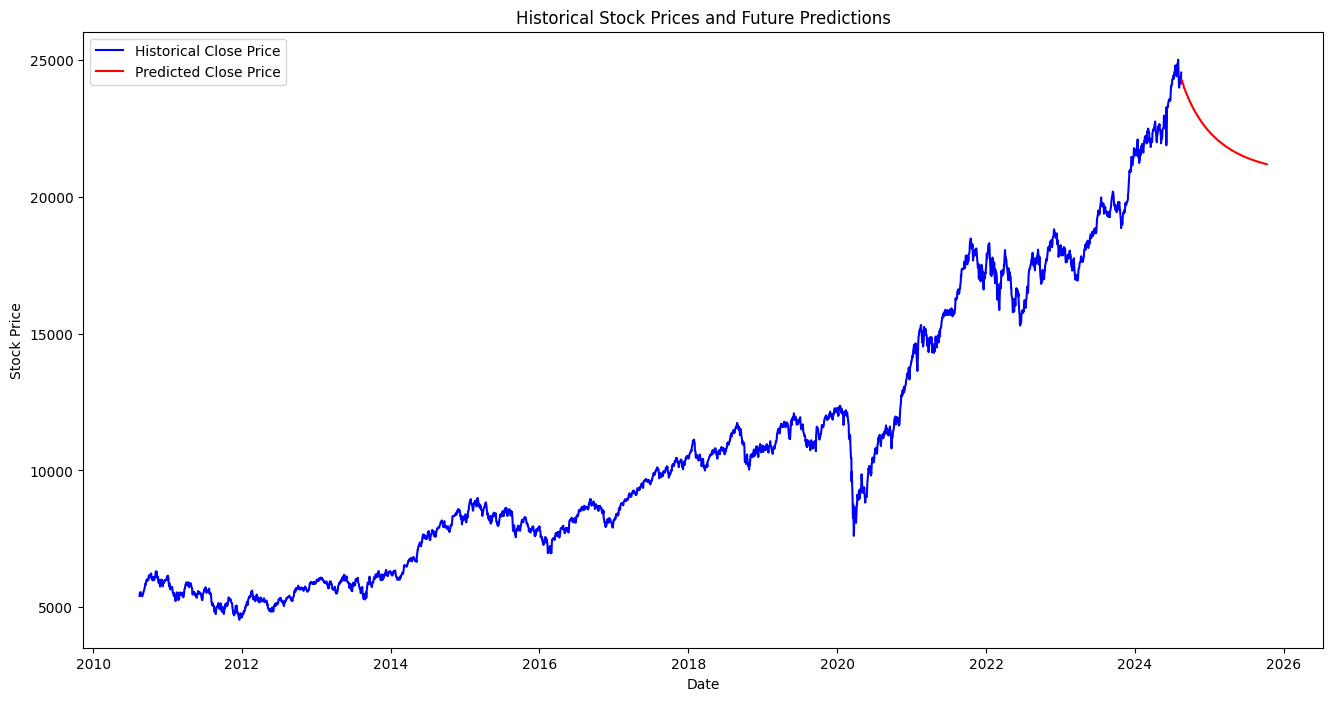

In [281]:
# Plot historical data and future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df["Date"], df['Close'], label='Historical Close Price', color='blue')

# Plot future predictions
plt.plot(future_df["Date"], future_df['Predicted_Close'], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Prices and Future Predictions')
plt.legend()
plt.show()

In [284]:
import plotly.graph_objects as go

# Create figure
fig = go.Figure()

# Add historical data trace
fig.add_trace(go.Scatter(
    x=df["Date"],
    y=df['Close'],
    mode='lines',
    name='Historical Close Price',
    line=dict(color='blue')
))

# Add future predictions trace
fig.add_trace(go.Scatter(
    x=future_df["Date"],
    y=future_df['Predicted_Close'],
    mode='lines',
    name='Predicted Close Price',
    line=dict(color='red')
))

# Update layout
fig.update_layout(
    title='Historical Stock Prices and Future Predictions',
    xaxis_title='Date',
    yaxis_title='Stock Price',
    legend_title='Legend',  # Optional: Use a dark theme, remove if not needed
)

# Show plot
fig.show()


Epoch 1/100


c:\Users\kk196\miniconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



49/49 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - loss: 0.0319 - val_loss: 0.0027
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0014 - val_loss: 5.1310e-04
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 7.7257e-04
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 9.4574e-04 - val_loss: 4.7268e-04
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 9.7774e-04 - val_loss: 0.0041
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0011 - val_loss: 4.7414e-04
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 9.5478e-04 - val_loss: 8.2530e-04
Epoch 9/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.0722e-04 - val_loss: 0.0015
Epoch 10/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 8.4473e-04 - val_loss: 3.5099e-04
Epoch 11/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 8.7277e-04 - val_loss: 0.0023
Epoch 12/100
49/

C:\Users\kk196\AppData\Local\Temp\ipykernel_22948\521904621.py:75: FutureWarning:

last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead



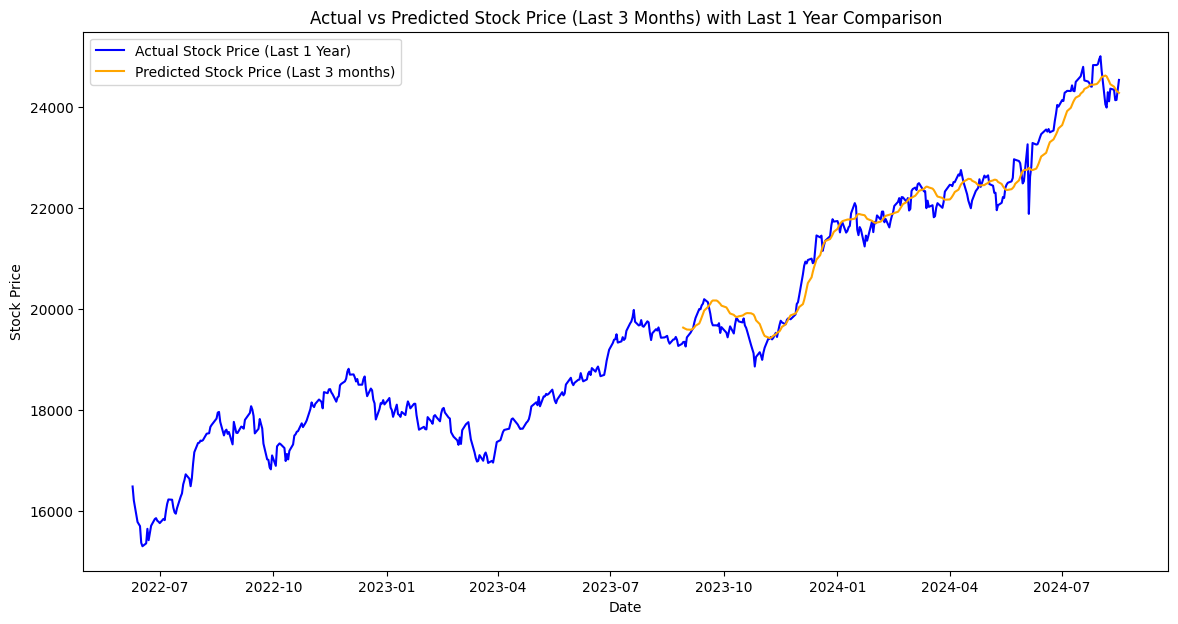

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━

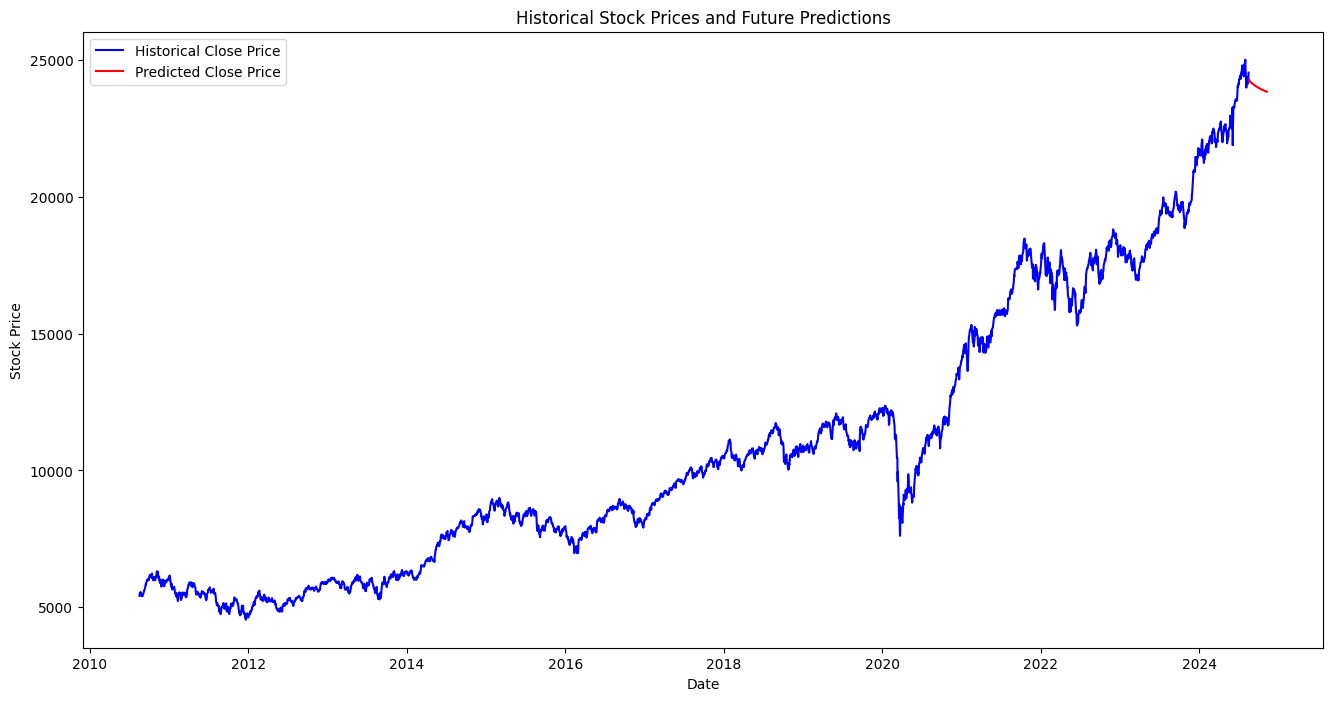

In [286]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load and prepare the data
df = pd.read_csv("NIFTY 50_Historical_PR_17082010to17082024.csv")
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')
data = df[['Date', 'Close']].set_index('Date')

# Additional feature (Volume) - Placeholder, adjust based on your dataset
# Assuming 'Volume' exists in your dataset; include it if available
# data['Volume'] = df['Volume']  # Uncomment if 'Volume' exists

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])
scaled_df = pd.DataFrame(scaled_data, index=data.index, columns=['Close'])

# Define the time step and the prediction period
time_step = 60

# Get the last 3 months for testing
last_3_months = 3 * 100  
test_data = scaled_df[-last_3_months:]
train_data = scaled_df[:-last_3_months]

def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step):
        X.append(data.iloc[i:(i + time_step), 0])
        y.append(data.iloc[i + time_step, 0])
    return np.array(X), np.array(y)

X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Build and train the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer=Adam(), loss='mean_squared_error')

# Train the model with early stopping
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluate the model on the last 3 months
test_predict = model.predict(X_test)
test_predict = scaler.inverse_transform(test_predict)

# Calculate RMSE for the last 3 months
test_rmse = math.sqrt(mean_squared_error(y_test, test_predict))
print(f'Test RMSE (Last 3 months): {test_rmse}')

# Define the time period for comparison
one_year = 800  # Adjust as needed if not precisely 365 days

# Extract the last year of actual data
last_year_data = data.last(f"{one_year}D")  # Last year of data

# Extract the indices for the last year of actual data
last_year_index = last_year_data.index

# Extract the last 3 months of actual data (aligned with test data)
last_3_months_index = data.index[-len(test_predict):]

# Plot 1: Comparison of the last 3 months actual vs predicted with 1-year window
plt.figure(figsize=(14, 7))

# Plot whole last year data
plt.plot(last_year_data.index, last_year_data['Close'], label='Actual Stock Price (Last 1 Year)', color='blue')

# Plot predicted values
plt.plot(last_3_months_index, test_predict, label='Predicted Stock Price (Last 3 months)', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Actual vs Predicted Stock Price (Last 3 Months) with Last 1 Year Comparison')
plt.legend()
plt.show()

def predict_nxt_yr():
    # Initialize the last 60 days of scaled data
    last_60_days = scaled_df['Close'].values[-60:].tolist()
    predictions = []

    for _ in range(60):
        # Prepare the input for prediction
        last_60_days_new = np.array(last_60_days[-60:]).reshape(1, time_step, 1)
        result = model.predict(last_60_days_new)

        # Append the predicted value to the last 60 days
        last_60_days.append(result[0, 0])
        predictions.append(result[0, 0])

    return predictions

nxt_yr = predict_nxt_yr()

# Inverse transform the predictions
future_predictions = scaler.inverse_transform(np.array(nxt_yr).reshape(-1, 1))

# Generate future dates starting from the day after the last date in historical data
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=60, freq='B')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted_Close': future_predictions.flatten()})

# Plot historical data and future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df["Date"], df['Close'], label='Historical Close Price', color='blue')

# Plot future predictions
plt.plot(future_df["Date"], future_df['Predicted_Close'], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Prices and Future Predictions')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

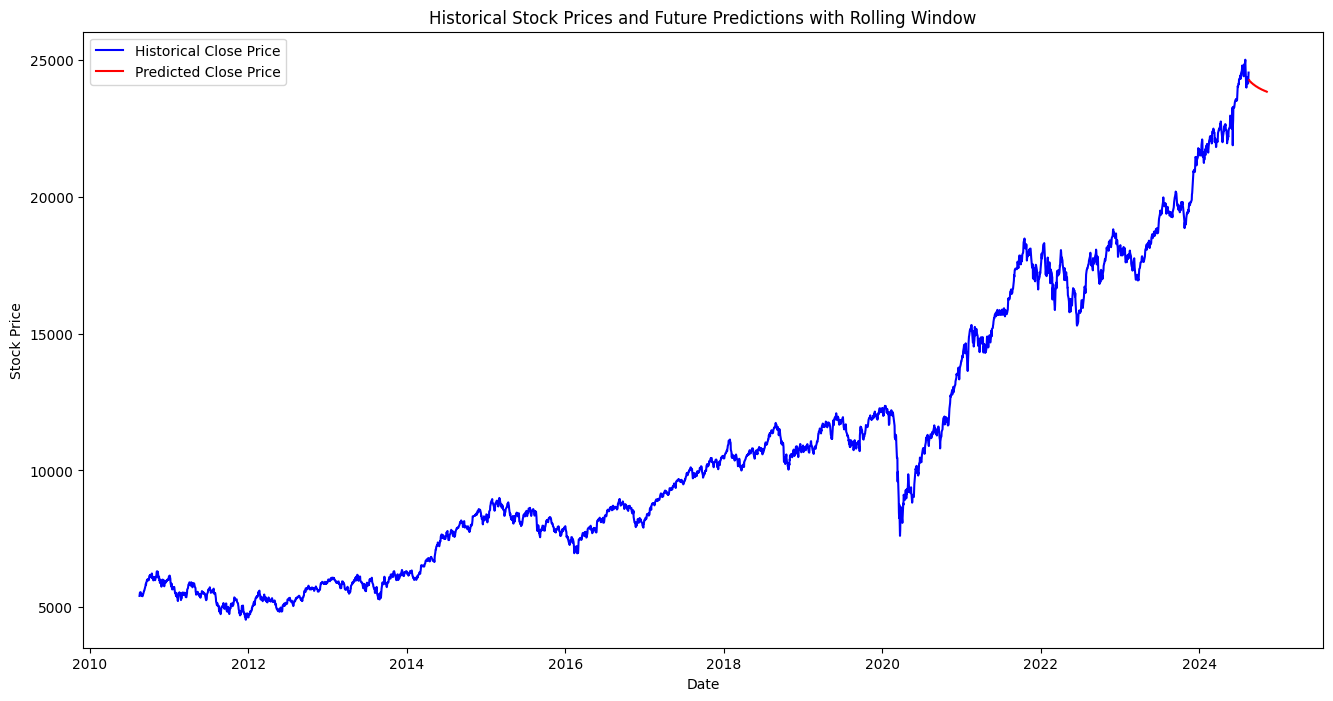

In [287]:
import numpy as np

def rolling_window_predict(model, data, time_step, n_predictions):
    # Convert data to scaled values
    scaled_data = scaler.transform(data[['Close']])
    predictions = []
    window = scaled_data[-time_step:]  # Initialize with the last `time_step` data points

    for _ in range(n_predictions):
        # Reshape the window for the model input
        window_input = window.reshape(1, time_step, 1)
        # Predict the next value
        predicted_scaled = model.predict(window_input)
        # Inverse transform the prediction
        predicted = scaler.inverse_transform(predicted_scaled)
        predictions.append(predicted[0, 0])
        
        # Update the window to include the latest prediction
        window = np.append(window[1:], predicted_scaled, axis=0)

    return predictions

# Example usage
n_predictions = 60  # Number of future time steps to predict
future_predictions = rolling_window_predict(model, df, time_step, n_predictions)

# Generate future dates
last_date = df['Date'].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_predictions, freq='B')

# Create a DataFrame for future predictions
future_df = pd.DataFrame(data={'Date': future_dates, 'Predicted_Close': future_predictions})

# Plot historical data and future predictions
plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(df["Date"], df['Close'], label='Historical Close Price', color='blue')

# Plot future predictions
plt.plot(future_df["Date"], future_df['Predicted_Close'], label='Predicted Close Price', color='red')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Historical Stock Prices and Future Predictions with Rolling Window')
plt.legend()
plt.show()
